# **Spark-Powered Personalised Finance Recommender with NLP**
This demo showcases an end-to-end scalable pipeline that combines Spark’s big data processing capabilities with advanced NLP techniques to analyse customer sentiment from financial product reviews. It leverages collaborative filtering (ALS) for personalised recommendations and sentiment analysis to augment or explain user feedback.

The pipeline explicitly manages cold-start scenarios using coldStartStrategy="drop", ensuring that predictions are only generated for valid user–item pairs seen during training. For explicit user–item predictions (transform()), coldStartStrategy="drop" removes unseen pairs. For top-N recommendations, ALS relies on learned user embeddings and does not require explicit item input.

It delivers actionable product recommendations and sentiment insights to enhance customer engagement and support data-driven decision-making in financial services.

**1. Environment Setup (PySpark in Colab):**

In [3]:
# Install Java and Apache Spark

# Install Java 11 (headless, no GUI) required for Spark to run
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
# Download Apache Spark 3.4.3 pre-built with Hadoop 3 support
!wget -q https://archive.apache.org/dist/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
# Extract the downloaded Spark archive
!tar -xzf spark-3.4.3-bin-hadoop3.tgz
# Install findspark, a helper library to locate Spark from Python
!pip install -q findspark

# Set environment variables
import os  # Required to set environment variables
# Tell Python/Spark where Java is installed
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# Tell Python/Spark where Spark is installed
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"

# Initialise findspark
# Configure Python to recognise the Spark installation
import findspark
findspark.init()

# Create a SparkSession
# SparkSession is the entry point to work with Spark DataFrames and ML pipelines
# appName() sets a name for this Spark job
# getOrCreate() starts Spark if not already running, or connects to an existing session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FinanceRecommender").getOrCreate()

**2. Prepare Test Data for Prediction (48 reviews from an uploaded text file)**

Upload the test dataset file 'finance_reviews.txt' containing 48 user–item interactions to demonstrate how the trained ALS and NLP models generate predictions.

- The dataset includes 6 users and 8 items, ensuring all user–item combinations align with the training set and avoid cold-start issues (coldStartStrategy="drop").

- Ratings are set to 0.0 to simulate unseen interactions for ALS predictions.

- Each interaction includes a review text from the uploaded finance_reviews.txt file to showcase sentiment prediction via the NLP pipeline.

- This setup demonstrates how collaborative filtering and NLP can jointly produce actionable recommendations and sentiment insights.

*NOTE: The training dataset contains 6 users and 8 items. By cycling through the same users and items in the test set, we ensure that ALS can generate predictions for all 48 interactions without filtering due to cold-start constraints.*

In [103]:
from pyspark.sql import Row
from pyspark.sql.functions import monotonically_increasing_id

# Upload the review data file 'finance_reviews.txt' to Colab before running this code

# Read the file to create the Spark DataFrame
with open("/content/finance_reviews.txt", "r") as f:
    reviews = [line.strip() for line in f.readlines() if line.strip()]

data = []
for line in reviews:
    userId, itemId, rating, review_text = line.split(",", 3)  # split only on first 3 commas
    data.append(Row(userId=int(userId), itemId=int(itemId), rating=float(rating), review_text=review_text))

training_df = spark.createDataFrame(data)
training_df.show(truncate=False)


+------+------+------+--------------------------------------------------+
|userId|itemId|rating|review_text                                       |
+------+------+------+--------------------------------------------------+
|1     |101   |3.0   |Good product, some improvements needed.           |
|1     |102   |5.0   |Outstanding product and features.                 |
|1     |103   |2.0   |Satisfactory but has issues.                      |
|1     |104   |2.0   |Features are limited and slow.                    |
|1     |105   |5.0   |Excellent service and very reliable.              |
|1     |106   |5.0   |Extremely satisfied, highly recommend.            |
|1     |107   |4.0   |Very good service, mostly satisfied.              |
|1     |108   |1.0   |Very disappointed with this product.              |
|2     |101   |3.0   |Helpful staff and clear information.              |
|2     |102   |1.0   |App crashes frequently and confusing.             |
|2     |103   |5.0   |Excellent servic

**3. Create a 'scalable' Spark NLP pipeline that processes user reviews:**

- Scalable: Uses distributed processing in Spark (not just small datasets in memory).
- NLP: Handles tokenisation, stopword removal, TF-IDF vectorisation.
- Pipeline Architecture: Prepares data for downstream ML tasks like classification or recommendation.

*This code shows ability to design scalable NLP pipelines using distributed frameworks, a key requirement for roles involving big data and AI at enterprise scale.*

In [104]:
# Import required Spark ML components

# Text processing components
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
# Classification model
from pyspark.ml.classification import LogisticRegression
# Pipeline API to chain stages together
from pyspark.ml import Pipeline
# Spark SQL helpers for creating labels
from pyspark.sql.functions import when, col

First define the Spark ML pipeline for scalable NLP, performing these actions:
- Binarise numeric ratings to use *proxy sentiment labels* for demonstrating scalable sentiment classification
- For the NLP pipeline:
  - Tokenisation
  - Stop word removal
  - TF-IDF vectorisation

*HashingTF + IDF is chosen vs CountVectorizer, as then scalable to large vocabularies and distributed datasets.*

*Create a binary sentiment label from ratings:*
- Logistic Regression requires a categorical label (not raw ratings)
- Convert numeric ratings into a binary sentiment proxy (a common practical shortcut when explicit sentiment labels are not available):

    rating >= 3  → positive sentiment (1.0)

    rating < 3   → negative sentiment (0.0)


In [105]:
from pyspark.sql.functions import when, col

# Add sentiment label to the test DataFrame
# Sentiment: 1.0 for rating >= 3 (positive), 0.0 otherwise (negative)
training_df = training_df.withColumn(
    "sentiment",
    when(col("rating") >= 3, 1.0).otherwise(0.0)
)

training_df.show(truncate=False)

+------+------+------+--------------------------------------------------+---------+
|userId|itemId|rating|review_text                                       |sentiment|
+------+------+------+--------------------------------------------------+---------+
|1     |101   |3.0   |Good product, some improvements needed.           |1.0      |
|1     |102   |5.0   |Outstanding product and features.                 |1.0      |
|1     |103   |2.0   |Satisfactory but has issues.                      |0.0      |
|1     |104   |2.0   |Features are limited and slow.                    |0.0      |
|1     |105   |5.0   |Excellent service and very reliable.              |1.0      |
|1     |106   |5.0   |Extremely satisfied, highly recommend.            |1.0      |
|1     |107   |4.0   |Very good service, mostly satisfied.              |1.0      |
|1     |108   |1.0   |Very disappointed with this product.              |0.0      |
|2     |101   |3.0   |Helpful staff and clear information.              |1.0

*Define the NLP feature pipeline:*

In [106]:
# Tokenise raw review text into individual words
tokenizer = Tokenizer(
    inputCol="review_text",
    outputCol="words"
)

# Remove common stopwords (e.g. "and", "the", "is")
# This reduces noise and dimensionality
remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered"
)

# Convert words into fixed-length numerical vectors
# HashingTF is scalable and avoids maintaining a vocabulary
tf = HashingTF(
    inputCol="filtered",
    outputCol="rawFeatures"
)

# Apply IDF weighting to downweight common words
idf = IDF(
    inputCol="rawFeatures",
    outputCol="features"
)

***Note:** This notebook focuses on a lightweight NLP pipeline for clarity.
More advanced extensions could include Named Entity Recognition (NER), richer sentiment classification, or BERT-based embeddings using Spark NLP.*

**4. Define the ML classification model:**

In [107]:
# Logistic Regression is used here for binary sentiment classification
# It predicts whether a review is positive (1) or negative (0)
classifier = LogisticRegression(
    featuresCol="features",
    labelCol="sentiment"
)

*Build and train the full Spark ML pipeline:*

In [108]:
# The pipeline chains together:
# Tokeniser → Stopword Removal → TF → IDF → Logistic Regression
nlp_pipeline = Pipeline(
    stages=[tokenizer, remover, tf, idf, classifier]
)

# Fit the pipeline on the training DataFrame
nlp_model = nlp_pipeline.fit(training_df)

*Run predictions:*

In [109]:
# Apply the trained pipeline to generate sentiment predictions
df_predicted = nlp_model.transform(training_df)

# Show predictions:
# prediction = model’s estimated sentiment label (0.0 or 1.0)
df_predicted.select(
    "userId",
    "itemId",
    "review_text",
    "sentiment",   # ground-truth proxy label
    "prediction"   # model output
).show(truncate=False)

+------+------+--------------------------------------------------+---------+----------+
|userId|itemId|review_text                                       |sentiment|prediction|
+------+------+--------------------------------------------------+---------+----------+
|1     |101   |Good product, some improvements needed.           |1.0      |1.0       |
|1     |102   |Outstanding product and features.                 |1.0      |1.0       |
|1     |103   |Satisfactory but has issues.                      |0.0      |0.0       |
|1     |104   |Features are limited and slow.                    |0.0      |0.0       |
|1     |105   |Excellent service and very reliable.              |1.0      |1.0       |
|1     |106   |Extremely satisfied, highly recommend.            |1.0      |1.0       |
|1     |107   |Very good service, mostly satisfied.              |1.0      |1.0       |
|1     |108   |Very disappointed with this product.              |0.0      |0.0       |
|2     |101   |Helpful staff and

Evaluation metrics for NLP:

In [110]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_predicted)
print(f"NLP Model Accuracy: {accuracy:.2f}")

NLP Model Accuracy: 1.00


**5. ALS Collaborative Filtering: Top-N Personalised Product Recommendation**

This component uses Spark MLlib’s Alternating Least Squares (ALS) algorithm to generate top-N personalised product recommendations for each user based on historical interactions.

- Algorithm: ALS collaborative filtering (implicit user–item preferences)
- Cold-start handling: Unseen user–item pairs are automatically filtered using coldStartStrategy="drop"
- Output: Ranked product recommendations with predicted preference scores

Personalisation use cases:

- Suggesting relevant financial tools or products to individual users
- Surfacing tailored investment or savings content
- Supporting downstream ranking and recommendation systems

Example ALS Recommendations per user:

The table below shows the top-N recommended products for each user, generated using ALS collaborative filtering.
Each recommendation consists of an `itemId` and a predicted preference score.
This is the core output that would be consumed by downstream personalisation or ranking systems.

In [111]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(
    userCol="userId",
    itemCol="itemId",
    ratingCol="rating",
    coldStartStrategy="drop"
)
als_model = als.fit(training_df)
userRecs = als_model.recommendForAllUsers(2)

userRecs.show(truncate=False)

+------+------------------------------------+
|userId|recommendations                     |
+------+------------------------------------+
|1     |[{102, 4.860061}, {106, 4.7012434}] |
|2     |[{109, 4.946187}, {103, 4.6105037}] |
|3     |[{103, 4.798598}, {106, 4.6492414}] |
|4     |[{102, 4.4583273}, {101, 2.8403506}]|
|5     |[{103, 4.7529507}, {104, 4.514322}] |
|6     |[{102, 3.8565001}, {108, 3.4183228}]|
+------+------------------------------------+



**6. ALS Model Serialisation (Optional in Colab):**

Both the ALS recommender and NLP pipeline are serialised using Spark ML’s native persistence mechanism, enabling reproducible loading, scalable inference, and deployment across distributed Spark environments without retraining.

In [112]:
als_model.write().overwrite().save("/content/als_model")
nlp_model.write().overwrite().save("/content/nlp_pipeline_model")

**7. Zip and download the model as archive folders:**

In [113]:
!zip -r als_model.zip /content/als_model
!zip -r nlp_pipeline_model.zip /content/nlp_pipeline_model

from google.colab import files
files.download('als_model.zip')
files.download('nlp_pipeline_model.zip')

updating: content/als_model/ (stored 0%)
updating: content/als_model/userFactors/ (stored 0%)
updating: content/als_model/userFactors/._SUCCESS.crc (stored 0%)
updating: content/als_model/userFactors/_SUCCESS (stored 0%)
updating: content/als_model/itemFactors/ (stored 0%)
updating: content/als_model/itemFactors/._SUCCESS.crc (stored 0%)
updating: content/als_model/itemFactors/_SUCCESS (stored 0%)
updating: content/als_model/metadata/ (stored 0%)
updating: content/als_model/metadata/.part-00000.crc (stored 0%)
updating: content/als_model/metadata/._SUCCESS.crc (stored 0%)
updating: content/als_model/metadata/_SUCCESS (stored 0%)
updating: content/als_model/metadata/part-00000 (deflated 40%)
  adding: content/als_model/userFactors/.part-00000-ec0d86c4-c14c-46e9-822e-0c385bf64896-c000.snappy.parquet.crc (stored 0%)
  adding: content/als_model/userFactors/part-00000-ec0d86c4-c14c-46e9-822e-0c385bf64896-c000.snappy.parquet (deflated 31%)
  adding: content/als_model/userFactors/.part-00002-

**8. Load the saved model components back to use them:**

In [115]:
from pyspark.ml.recommendation import ALSModel
from pyspark.ml import PipelineModel

# Load ALS model
als_model_loaded = ALSModel.load("/content/als_model")

# Load NLP pipeline model
nlp_model_loaded = PipelineModel.load("/content/nlp_pipeline_model")

**9. Prepare some example input data for use with the loaded model:**
- Create a small DataFrame similar to the training data to run predictions on, with various reviews and ratings from different users.
- The prepared dataset will be used to demonstrate predictions of the ALS recommendation model (personalised recommendations) and the NLP sentiment classification model.


In [116]:
from pyspark.sql import Row

input_data = [
    Row(userId=1, itemId=103, rating=0.0, review_text="Unreliable service and support is unhelpful."),
    Row(userId=2, itemId=101, rating=0.0, review_text="Sophisticated investment tools and competitive loan rates."),
    Row(userId=3, itemId=104, rating=0.0, review_text="Excellent mobile app experience and fast transfers."),
    Row(userId=4, itemId=105, rating=0.0, review_text="High minimum balance and confusing terms."),
    Row(userId=5, itemId=106, rating=0.0, review_text="Good savings plan and clear statements."),
]

input_df = spark.createDataFrame(input_data)


***Note: Verifying user/item IDs in test data vs training data***

- Cold start problem: By default, the ALS model cannot predict for user or item IDs that were not present in the training data. These unknown users/items get filtered out (especially if you used coldStartStrategy="drop").

- Therefore in the input data, if test_df above contains user or item IDs that do not appear in the training data set, predictions for those pairs will be missing because the model does not know how to handle making predictions for them.

In [117]:
training_df.select("userId").distinct().show()
training_df.select("itemId").distinct().show()

input_df.select("userId").distinct().show()
input_df.select("itemId").distinct().show()

+------+
|userId|
+------+
|     1|
|     3|
|     2|
|     6|
|     5|
|     4|
+------+

+------+
|itemId|
+------+
|   107|
|   103|
|   104|
|   106|
|   105|
|   108|
|   101|
|   102|
|   109|
|   110|
+------+

+------+
|userId|
+------+
|     1|
|     2|
|     5|
|     3|
|     4|
+------+

+------+
|itemId|
+------+
|   103|
|   101|
|   104|
|   106|
|   105|
+------+



**10. Run predictions:**

For the ALS recommendation model (predict ratings or get recommendations):
- Learns embeddings for users and items
- Makes predictions based on user–item interactions only

Intended output: 'User (ID) is likely to rate Item (ID) around level (prediction)'

*Expected Output:*

For the ALS model:
- It will recommend products/items to users based on their past ratings and preferences.

For the NLP sentiment model:
- It will predict whether the review sentiment is positive or negative (classification scheme set up in this case was >= 3 classified as a '1' positive, otherwise '0' negative).

Interpreting NaN Ratings:
- The user has no historical rating for that item; the interaction is unseen in the training data.

In [118]:
# Convert Spark training test_df to pandas for rating merge
training_df_pd = training_df.toPandas()

# Merge predictions with actual ratings
test_pred_with_rating = training_df_pd.merge(training_df_pd[['userId', 'itemId', 'rating']], on=['userId', 'itemId'], how='left')
display(test_pred_with_rating)

,userId,itemId,rating_x,review_text,sentiment,rating_y
0,1,101,3.0,"Good product, some improvements needed.",1.0,3.0
1,1,102,5.0,Outstanding product and features.,1.0,5.0
2,1,103,2.0,Satisfactory but has issues.,0.0,2.0
3,1,104,2.0,Features are limited and slow.,0.0,2.0
4,1,105,5.0,Excellent service and very reliable.,1.0,5.0
5,1,106,5.0,"Extremely satisfied, highly recommend.",1.0,5.0
6,1,107,4.0,"Very good service, mostly satisfied.",1.0,4.0
7,1,108,1.0,Very disappointed with this product.,0.0,1.0
8,2,101,3.0,Helpful staff and clear information.,1.0,3.0
9,2,102,1.0,App crashes frequently and confusing.,0.0,1.0


*Cold Start Problem in Collaborative Filtering*

The cold start problem occurs when the ALS (Alternating Least Squares) model encounters new users or items that were not part of the training dataset. Since ALS relies on previous ratings, it cannot predict for users or items that are unseen in the model's training phase. In this demonstration, we explicitly configured ALS to drop unseen user–item pairs.

In [119]:
from pyspark.sql.functions import round, col

# Run ALS predictions
als_predictions = als_model.transform(input_df)

# Round ALS predictions for readability
als_predictions = als_predictions.withColumn("predicted_rating", round("prediction", 2))

#  IMPORTANT: Rename the review_text column in the input_df dataset
#  as the training_df dataset and input_df dataset use an identical review text column name, this ensures no ambiguity)
input_df_renamed = input_df.select(
    col("userId"),
    col("itemId"),
    col("review_text").alias("input_review_text")
)

# Join ALS predictions with test data review text
als_with_text = als_predictions.join(
    input_df_renamed,
    on=["userId", "itemId"],
    how="left"
)

# Select only the columns we need
als_with_text.select(
    col("userId"),
    col("itemId"),
    col("input_review_text").alias("review_text"),
    col("predicted_rating")
).show(truncate=False)

+------+------+----------------------------------------------------------+----------------+
|userId|itemId|review_text                                               |predicted_rating|
+------+------+----------------------------------------------------------+----------------+
|4     |105   |High minimum balance and confusing terms.                 |1.31            |
|3     |104   |Excellent mobile app experience and fast transfers.       |3.02            |
|2     |101   |Sophisticated investment tools and competitive loan rates.|2.88            |
|1     |103   |Unreliable service and support is unhelpful.              |2.21            |
|5     |106   |Good savings plan and clear statements.                   |4.02            |
+------+------+----------------------------------------------------------+----------------+



The NLP pipeline (predict sentiment or classification):
- Learns from language content
- Predicts sentiment, often used to augment or explain ratings

**NLP Outputs Explained:**

Predictions show the predicted class label (e.g., sentiment) for the input text.

*5 could mean most the positive sentiment, and 0 means negative*

In [120]:
nlp_predictions = nlp_model.transform(training_df)

# Convert NLP predictions to pandas
training_pred_pd = nlp_predictions.select("userId", "itemId", "prediction").toPandas()

# nlp_predictions = nlp_model_loaded.transform(test_df)
nlp_predictions.select("userId", "itemId", "review_text", "prediction").show()

+------+------+--------------------+----------+
|userId|itemId|         review_text|prediction|
+------+------+--------------------+----------+
|     1|   101|Good product, som...|       1.0|
|     1|   102|Outstanding produ...|       1.0|
|     1|   103|Satisfactory but ...|       0.0|
|     1|   104|Features are limi...|       0.0|
|     1|   105|Excellent service...|       1.0|
|     1|   106|Extremely satisfi...|       1.0|
|     1|   107|Very good service...|       1.0|
|     1|   108|Very disappointed...|       0.0|
|     2|   101|Helpful staff and...|       1.0|
|     2|   102|App crashes frequ...|       0.0|
|     2|   103|Excellent service...|       1.0|
|     2|   104|High fees and slo...|       0.0|
|     2|   105|Difficult to navi...|       0.0|
|     2|   106|Service is averag...|       0.0|
|     2|   107|Customer support ...|       1.0|
|     2|   108|Satisfactory but ...|       0.0|
|     2|   109|Sophisticated inv...|       1.0|
|     3|   101|Top-notch support...|    

**ALS Outputs Explained:**

Prediction shows the estimated rating for user-item pairs, which you can interpret as a recommendation score.

*Alignment between ALS and NLP:*

High predicted NLP sentiment + high predicted ALS rating → strong positive signal for recommendation.

**11. Display the predicted results**

 Display training data predictions as table:

In [121]:
import pandas as pd

# Convert Spark DataFrame (training data predictions) to pandas for display
df_predicted_pd = df_predicted.select("userId", "itemId", "review_text", "prediction").toPandas()

# Show the table
df_predicted_pd

,userId,itemId,review_text,prediction
0,1,101,"Good product, some improvements needed.",1.0
1,1,102,Outstanding product and features.,1.0
2,1,103,Satisfactory but has issues.,0.0
3,1,104,Features are limited and slow.,0.0
4,1,105,Excellent service and very reliable.,1.0
5,1,106,"Extremely satisfied, highly recommend.",1.0
6,1,107,"Very good service, mostly satisfied.",1.0
7,1,108,Very disappointed with this product.,0.0
8,2,101,Helpful staff and clear information.,1.0
9,2,102,App crashes frequently and confusing.,0.0


Display predicted sentiment results:

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate NLP predictions for the input test dataset
input_nlp_pred = nlp_model.transform(input_df)

# Convert predictions to pandas for display and merging
# Include review text for display
df_predicted_pd = input_nlp_pred.select(
    "userId",
    "itemId",
    "review_text",
    "prediction"
).toPandas()

# Display predicted sentiments with review text
display(df_predicted_pd)

,userId,itemId,review_text,prediction
0,1,103,Unreliable service and support is unhelpful.,0.0
1,2,101,Sophisticated investment tools and competitive...,1.0
2,3,104,Excellent mobile app experience and fast trans...,1.0
3,4,105,High minimum balance and confusing terms.,0.0
4,5,106,Good savings plan and clear statements.,1.0


Display merged table, prepared for plotting (sentiment predictions against ratings) :

In [123]:
# Prepare data for plotting by merging predicted sentiments with actual ratings
training_df_pd = training_df.toPandas()

# Keep only userId, itemId, and prediction for merging
input_pred_pd = df_predicted_pd[['userId', 'itemId', 'prediction']]

# Merge predictions with actual ratings (for known user-item pairs)
test_pred_with_rating = input_pred_pd.merge(
    training_df_pd[['userId', 'itemId', 'rating']],
    on=['userId', 'itemId'],
    how='left'
)

# Drop any rows with missing ratings (optional, ensures clean visualisation)
test_pred_with_rating.dropna(subset=['rating'], inplace=True)

# Display the merged table
display(test_pred_with_rating)

# Create a pivot table for the sentiment heatmap
sentiment_pivot = test_pred_with_rating.pivot(
    index='userId',
    columns='itemId',
    values='prediction'
)

,userId,itemId,prediction,rating
0,1,103,0.0,2.0
1,2,101,1.0,3.0
2,3,104,1.0,3.0
3,4,105,0.0,1.0
4,5,106,1.0,4.0


Top-K product recommendations per user (highest-ranked results):

In [127]:
# Generate top-K product recommendations per user using ALS
userRecs = als_model.recommendForAllUsers(3)

# Convert Spark DataFrame to pandas for easy inspection in Colab
user_recs_pd = userRecs.toPandas()

# Display recommended items per user (demo / interpretability only)
display(user_recs_pd)

,userId,recommendations
0,1,"[(102, 4.860061168670654), (106, 4.70124340057..."
1,2,"[(109, 4.9461870193481445), (103, 4.6105036735..."
2,3,"[(103, 4.798597812652588), (106, 4.64924144744..."
3,4,"[(102, 4.458327293395996), (101, 2.84035062789..."
4,5,"[(103, 4.752950668334961), (104, 4.51432180404..."
5,6,"[(102, 3.8565001487731934), (108, 3.4183228015..."


### **Heatmap of Predicted Sentiments**
The heatmap visualises the predicted sentiment of user reviews based on the trained NLP model. The sentiment score ranges from negative to positive, where lighter colors indicate more positive sentiments. This is helpful for quickly understanding user feedback and detecting areas that may need improvement in a product or service.

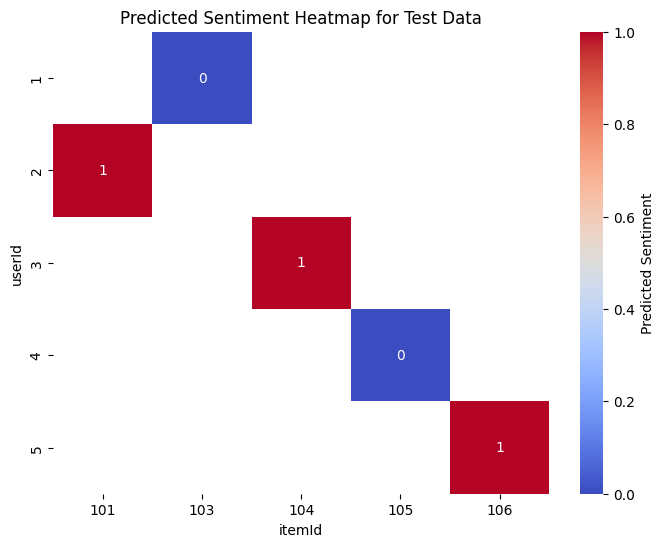

In [125]:
# Plot heatmap of predicted sentiment
plt.figure(figsize=(8,6))
sns.heatmap(sentiment_pivot.round(1), annot=True, cmap="coolwarm", cbar_kws={'label': 'Predicted Sentiment'})
plt.title("Predicted Sentiment Heatmap for Test Data")
plt.show()

### **Bar Plot Comparing Actual Ratings and Predicted Sentiment**
This bar plot compares the actual ratings given by users with the predicted sentiment scores from the NLP model. Blue bars represent actual ratings, while red bars indicate predicted sentiment: a red bar shows 1 if the blue rating is 3 or above, and 0 otherwise. This visual helps assess how well the NLP model’s sentiment predictions align with the user-provided ratings.

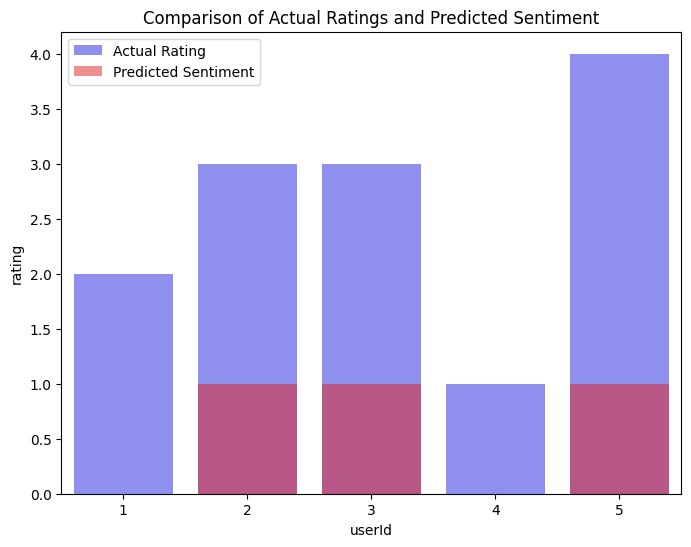

In [126]:
# Plot bar plot comparing actual ratings and predicted sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='userId', y='rating', data=test_pred_with_rating, color='blue', alpha=0.5, label='Actual Rating')
sns.barplot(x='userId', y='prediction', data=test_pred_with_rating, color='red', alpha=0.5, label='Predicted Sentiment')
plt.title("Comparison of Actual Ratings and Predicted Sentiment")
plt.legend()
plt.show()

Export Test Data:

In [75]:
# Save test data for download as CSV (optional)
test_pred_with_rating.to_csv('/content/test_data.csv', index=False)

# Trigger download of the CSV file
from google.colab import files
files.download('/content/test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>